<a href="https://colab.research.google.com/github/Rbiswas0820/Rbiswas/blob/main/TELEGRAPHY_DATA_ANALYSIS_FOR_BRAKE_FAILURE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# written by Misty Biswas@

# Problem Statement
We have the telemetry data for every 0.5s for lime scooters. This data includes left and/or right brake voltage, speed data. The question we want to answer is how many brake failure occured in the given dataset. 


# Assumptions

1. Speed:The speed of the scooter needs to be higher than 5mph to be considered for a brake failure.

2. Brake Application:A threshold of 1V is used to determine whether brake has been applied in the scooter for that time period or not. Some scooters have left brake, some has both left and right brake. If any of the left/right brake value is higher than 1V then brake has been applied.

3. Brake Failour:If brake applied for 5s consecutively (10 Time intervals) and the speed does not go down by 1 mph, then it is considered a brake failure. 




# Query and Filtering Data

Data is filtered based on
##### 1. left or right brake is applied
##### 2. Speed greater than 5 mph

 The following snowflake query has been used for filtering. 

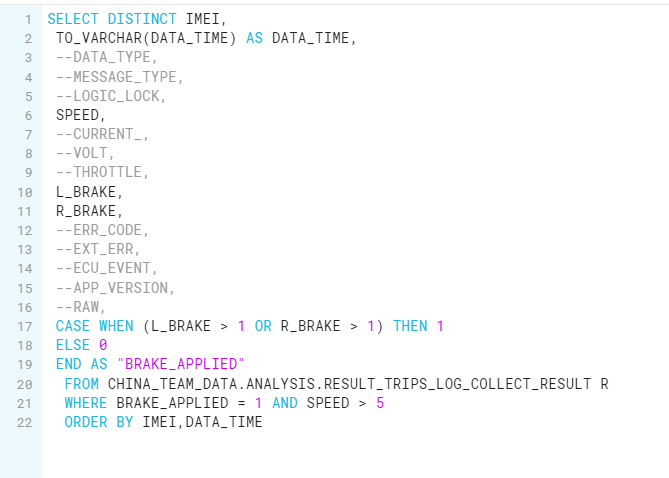


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Reading the Filtered Telemetry data



In [3]:
# reading monthly csv files and stacking

df= pd.read_csv('Braking_Data_df.csv')

In [4]:
df.head(10)

,IMEI,DATA_TIME,LOGIC_LOCK,SPEED,THROTTLE,L_BRAKE,R_BRAKE,BRAKE_APPLIED
0,869307030836489,2022-02-16 23:35:14.438,241,5.3,3.8750,1.0175,NaN,1
1,869307030836489,2022-02-16 23:35:14.939,241,5.5,3.3975,1.0150,NaN,1
2,869307030836489,2022-02-16 23:35:15.943,241,5.5,2.9250,1.0075,NaN,1
3,869307030836489,2022-02-16 23:35:33.036,241,7.5,3.7050,1.0050,NaN,1
4,869307030836489,2022-02-16 23:39:50.218,241,9.3,0.9150,1.6900,NaN,1
5,869307030836489,2022-02-16 23:40:26.044,241,8.8,1.0425,2.9775,NaN,1
6,869307030836489,2022-02-16 23:40:26.586,241,7.4,2.3100,3.1275,NaN,1
7,869307030836489,2022-02-16 23:40:27.047,241,5.4,2.3750,3.0650,NaN,1
8,869307030836489,2022-02-16 23:40:40.892,241,11.0,0.9450,1.4675,NaN,1
9,869307030836489,2022-02-16 23:40:41.608,241,9.6,0.9425,1.4150,NaN,1


Data Cleaning



In [5]:
# Getting rid of the unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [6]:
df = df[~df['IMEI'].isin(['869313035652889','869307034156413','869307034132372'])]

ADDITIONAL COLUMNS 

1.   SPEED_DIFF: this column calculates the speed difference for a row from the next row of data for the same IMEI group 
2.   TIME_DIFF: this column calculates the time difference in seconds for a row from the next row of data for the same IMEI group
3.  TIME_DIFF_BIN : this is a binary column to keep track of the time difference, if the time difference between two rows is less than 0.6s, this column value will be 1, otherwise 0. The goal of this column is to keep track if a brake failure event is continueing in the next time interval.
4. SPEED_CUSUM: Calculates the cumulative speed for consecutive braking events by IMEI group
5. TP_CUSUM: Calcualtes cumulative sum of the TIME_DIFF_BIN column. This column keep tracks of how many sec brake is applied consecutively by a scooter.






In [7]:
df['SPEED_DIFF'] = df.groupby('IMEI')['SPEED'].diff(-1)*-1

In [8]:
df['DATE_TIME_dt'] = pd.to_datetime(df['DATA_TIME'].astype(str))

In [9]:
df['TIME_DIFF'] = df.groupby('IMEI')['DATE_TIME_dt'].diff(-1).dt.total_seconds()*-1

In [10]:
df['TIME_DIFF_BIN'] = np.where(df['TIME_DIFF']<0.6,1,0)

In [11]:
df.drop(columns='DATE_TIME_dt',inplace=True)

In [12]:
df.head(10)

,IMEI,DATA_TIME,LOGIC_LOCK,SPEED,THROTTLE,L_BRAKE,R_BRAKE,BRAKE_APPLIED,SPEED_DIFF,TIME_DIFF,TIME_DIFF_BIN
0,869307030836489,2022-02-16 23:35:14.438,241,5.3,3.8750,1.0175,NaN,1,0.2,0.501,1
1,869307030836489,2022-02-16 23:35:14.939,241,5.5,3.3975,1.0150,NaN,1,-0.0,1.004,0
2,869307030836489,2022-02-16 23:35:15.943,241,5.5,2.9250,1.0075,NaN,1,2.0,17.093,0
3,869307030836489,2022-02-16 23:35:33.036,241,7.5,3.7050,1.0050,NaN,1,1.8,257.182,0
4,869307030836489,2022-02-16 23:39:50.218,241,9.3,0.9150,1.6900,NaN,1,-0.5,35.826,0
5,869307030836489,2022-02-16 23:40:26.044,241,8.8,1.0425,2.9775,NaN,1,-1.4,0.542,1
6,869307030836489,2022-02-16 23:40:26.586,241,7.4,2.3100,3.1275,NaN,1,-2.0,0.461,1
7,869307030836489,2022-02-16 23:40:27.047,241,5.4,2.3750,3.0650,NaN,1,5.6,13.845,0
8,869307030836489,2022-02-16 23:40:40.892,241,11.0,0.9450,1.4675,NaN,1,-1.4,0.716,0
9,869307030836489,2022-02-16 23:40:41.608,241,9.6,0.9425,1.4150,NaN,1,-1.1,22.020,0


In [13]:
df[df['TIME_DIFF_BIN']==True]

,IMEI,DATA_TIME,LOGIC_LOCK,SPEED,THROTTLE,L_BRAKE,R_BRAKE,BRAKE_APPLIED,SPEED_DIFF,TIME_DIFF,TIME_DIFF_BIN
0,869307030836489,2022-02-16 23:35:14.438,241,5.3,3.8750,1.0175,NaN,1,0.2,0.501,1
5,869307030836489,2022-02-16 23:40:26.044,241,8.8,1.0425,2.9775,NaN,1,-1.4,0.542,1
6,869307030836489,2022-02-16 23:40:26.586,241,7.4,2.3100,3.1275,NaN,1,-2.0,0.461,1
11,869307030836489,2022-02-16 23:41:04.627,241,7.6,2.1800,1.1775,NaN,1,-0.5,0.487,1
12,869307030836489,2022-02-16 23:41:05.114,241,7.1,2.1800,1.1775,NaN,1,-0.5,0.542,1
...,...,...,...,...,...,...,...,...,...,...,...
317954,869715035688517,2022-01-19 04:17:00.728,241,8.5,2.2375,1.1925,NaN,1,-0.3,0.548,1
317955,869715035688517,2022-01-19 04:17:01.276,241,8.2,1.1500,1.1950,NaN,1,-0.7,0.454,1
317956,869715035688517,2022-01-19 04:17:01.730,241,7.5,1.1450,1.1875,NaN,1,-0.7,0.544,1
317957,869715035688517,2022-01-19 04:17:02.274,241,6.8,1.1500,1.1900,NaN,1,-0.8,0.458,1


In [14]:
#List of unique bikes in the data 
IMEI_list = df['IMEI'].unique()


In [15]:
#Number of unique bikes in the data 
df['IMEI'].nunique()

231

In [16]:
group_IMEI = df.groupby('IMEI')

In [17]:
df['TP_CUMSUM']=df.groupby(df['TIME_DIFF_BIN'].eq(0).cumsum())['TIME_DIFF_BIN'].cumsum() 

In [18]:
df.loc[df['TP_CUMSUM']==1,'TIME_DIFF_BIN']=0

In [19]:
df['SPEED_CUMSUM']=df.groupby(df['TIME_DIFF_BIN'].eq(0).cumsum())['SPEED_DIFF'].cumsum()    

In [20]:
df['SPEED_CUMSUM']=df['SPEED_CUMSUM'].fillna(0)

In [21]:
df.loc[df['TP_CUMSUM']==1,'TIME_DIFF_BIN']=1

In [22]:
df.head(10)

,IMEI,DATA_TIME,LOGIC_LOCK,SPEED,THROTTLE,L_BRAKE,R_BRAKE,BRAKE_APPLIED,SPEED_DIFF,TIME_DIFF,TIME_DIFF_BIN,TP_CUMSUM,SPEED_CUMSUM
0,869307030836489,2022-02-16 23:35:14.438,241,5.3,3.8750,1.0175,NaN,1,0.2,0.501,1,1,0.2
1,869307030836489,2022-02-16 23:35:14.939,241,5.5,3.3975,1.0150,NaN,1,-0.0,1.004,0,0,0.0
2,869307030836489,2022-02-16 23:35:15.943,241,5.5,2.9250,1.0075,NaN,1,2.0,17.093,0,0,2.0
3,869307030836489,2022-02-16 23:35:33.036,241,7.5,3.7050,1.0050,NaN,1,1.8,257.182,0,0,1.8
4,869307030836489,2022-02-16 23:39:50.218,241,9.3,0.9150,1.6900,NaN,1,-0.5,35.826,0,0,-0.5
5,869307030836489,2022-02-16 23:40:26.044,241,8.8,1.0425,2.9775,NaN,1,-1.4,0.542,1,1,-1.4
6,869307030836489,2022-02-16 23:40:26.586,241,7.4,2.3100,3.1275,NaN,1,-2.0,0.461,1,2,-3.4
7,869307030836489,2022-02-16 23:40:27.047,241,5.4,2.3750,3.0650,NaN,1,5.6,13.845,0,0,5.6
8,869307030836489,2022-02-16 23:40:40.892,241,11.0,0.9450,1.4675,NaN,1,-1.4,0.716,0,0,-1.4
9,869307030836489,2022-02-16 23:40:41.608,241,9.6,0.9425,1.4150,NaN,1,-1.1,22.020,0,0,-1.1


In [23]:
df.iloc[1059:1070,:]

,IMEI,DATA_TIME,LOGIC_LOCK,SPEED,THROTTLE,L_BRAKE,R_BRAKE,BRAKE_APPLIED,SPEED_DIFF,TIME_DIFF,TIME_DIFF_BIN,TP_CUMSUM,SPEED_CUMSUM
1059,869307030836489,2022-02-19 05:19:33.087,241,8.6,0.9500,1.7375,NaN,1,-0.7,0.454,1,3,-2.1
1060,869307030836489,2022-02-19 05:19:33.541,241,7.9,0.9500,1.7275,NaN,1,-0.8,0.545,1,4,-2.9
1061,869307030836489,2022-02-19 05:19:34.086,241,7.1,0.9500,1.6775,NaN,1,-0.6,0.460,1,5,-3.5
1062,869307030836489,2022-02-19 05:19:34.546,241,6.5,0.9500,1.6200,NaN,1,-0.5,0.549,1,6,-4.0
1063,869307030836489,2022-02-19 05:19:35.095,241,6.0,0.9500,1.5000,NaN,1,NaN,NaN,0,0,0.0
1064,869307031397275,2021-10-10 04:51:58.479,241,8.7,0.8675,2.2750,NaN,1,-2.4,20.551,0,0,-2.4
1065,869307031397275,2021-10-10 04:52:19.030,241,6.3,3.5475,1.0050,NaN,1,3.5,20.131,0,0,3.5
1066,869307031397275,2021-10-10 04:52:39.161,241,9.8,3.5725,1.0050,NaN,1,1.3,8.459,0,0,1.3
1067,869307031397275,2021-10-10 04:52:47.620,241,11.1,0.8725,2.1875,NaN,1,-1.3,0.808,0,0,-1.3
1068,869307031397275,2021-10-10 04:52:48.428,241,9.8,2.4975,1.4050,NaN,1,4.3,7.913,0,0,4.3


# Writing the raw brake failure data

In [24]:
df.to_csv('raw_data_brake_fail.csv')

In [25]:
brake_5_sec_df = df[df['TP_CUMSUM']==9]

In [26]:
brake_5_sec_df

,IMEI,DATA_TIME,LOGIC_LOCK,SPEED,THROTTLE,L_BRAKE,R_BRAKE,BRAKE_APPLIED,SPEED_DIFF,TIME_DIFF,TIME_DIFF_BIN,TP_CUMSUM,SPEED_CUMSUM
69,869307030836489,2022-02-17 13:50:48.965,241,5.2,1.0800,1.0400,NaN,1,-0.1,0.455,1,9,-3.5
99,869307030836489,2022-02-17 13:51:13.525,241,11.5,3.8200,1.0225,NaN,1,0.2,0.458,1,9,1.9
109,869307030836489,2022-02-17 13:51:20.021,241,11.9,3.8600,1.0600,NaN,1,-0.3,0.545,1,9,0.3
173,869307030836489,2022-02-17 13:51:57.372,241,11.1,3.8175,1.0150,NaN,1,0.2,0.542,1,9,1.6
230,869307030836489,2022-02-17 15:30:48.985,241,10.2,3.9025,1.1275,NaN,1,0.1,0.503,1,9,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317540,869715035688517,2022-01-18 16:05:59.209,241,14.7,3.5575,1.0175,NaN,1,-0.0,0.458,1,9,0.2
317581,869715035688517,2022-01-18 16:06:21.270,241,11.6,3.5675,1.0125,NaN,1,0.2,0.460,1,9,6.0
317662,869715035688517,2022-01-18 16:07:03.009,241,13.2,3.5600,1.0125,NaN,1,0.7,0.453,1,9,-0.7
317723,869715035688517,2022-01-19 04:15:03.285,241,6.8,3.7300,1.2750,NaN,1,-0.0,0.460,1,9,1.6


In [27]:
brake_applied = len(df.index)
brake_applied

317960

In [28]:
speed_drop_1mph_df = brake_5_sec_df['SPEED_CUMSUM']<=-1 

In [29]:
No_brake_failure_df = brake_5_sec_df[speed_drop_1mph_df]
No_brake_failure_df

,IMEI,DATA_TIME,LOGIC_LOCK,SPEED,THROTTLE,L_BRAKE,R_BRAKE,BRAKE_APPLIED,SPEED_DIFF,TIME_DIFF,TIME_DIFF_BIN,TP_CUMSUM,SPEED_CUMSUM
69,869307030836489,2022-02-17 13:50:48.965,241,5.2,1.0800,1.0400,NaN,1,-0.1,0.455,1,9,-3.5
251,869307030836489,2022-02-17 15:31:05.637,241,7.8,1.0650,1.0175,NaN,1,-0.6,0.459,1,9,-4.0
640,869307030836489,2022-02-18 03:38:11.062,241,11.0,3.8200,1.0425,NaN,1,-0.0,0.546,1,9,-2.1
668,869307030836489,2022-02-18 03:38:39.412,241,8.6,3.8075,1.4550,NaN,1,-0.6,0.545,1,9,-4.8
695,869307030836489,2022-02-18 04:40:47.115,241,11.4,1.1725,1.0100,NaN,1,-0.5,0.550,1,9,-2.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
315831,869715035688517,2022-01-18 14:44:53.580,241,12.6,3.6850,1.2150,NaN,1,0.1,0.453,1,9,-2.1
316206,869715035688517,2022-01-18 14:48:52.020,241,13.6,3.6100,1.1075,NaN,1,-0.9,0.502,1,9,-2.4
316510,869715035688517,2022-01-18 15:55:28.301,241,5.8,3.6125,1.1075,NaN,1,-0.0,0.453,1,9,-1.2
316748,869715035688517,2022-01-18 15:59:05.177,241,7.5,1.0050,1.0250,NaN,1,-0.2,0.453,1,9,-2.4


In [30]:
brake_failed_df = brake_5_sec_df[~speed_drop_1mph_df]
brake_failed_df

,IMEI,DATA_TIME,LOGIC_LOCK,SPEED,THROTTLE,L_BRAKE,R_BRAKE,BRAKE_APPLIED,SPEED_DIFF,TIME_DIFF,TIME_DIFF_BIN,TP_CUMSUM,SPEED_CUMSUM
99,869307030836489,2022-02-17 13:51:13.525,241,11.5,3.8200,1.0225,NaN,1,0.2,0.458,1,9,1.9
109,869307030836489,2022-02-17 13:51:20.021,241,11.9,3.8600,1.0600,NaN,1,-0.3,0.545,1,9,0.3
173,869307030836489,2022-02-17 13:51:57.372,241,11.1,3.8175,1.0150,NaN,1,0.2,0.542,1,9,1.6
230,869307030836489,2022-02-17 15:30:48.985,241,10.2,3.9025,1.1275,NaN,1,0.1,0.503,1,9,0.5
290,869307030836489,2022-02-17 15:32:54.108,241,10.6,3.8275,1.0175,NaN,1,0.2,0.459,1,9,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317540,869715035688517,2022-01-18 16:05:59.209,241,14.7,3.5575,1.0175,NaN,1,-0.0,0.458,1,9,0.2
317581,869715035688517,2022-01-18 16:06:21.270,241,11.6,3.5675,1.0125,NaN,1,0.2,0.460,1,9,6.0
317662,869715035688517,2022-01-18 16:07:03.009,241,13.2,3.5600,1.0125,NaN,1,0.7,0.453,1,9,-0.7
317723,869715035688517,2022-01-19 04:15:03.285,241,6.8,3.7300,1.2750,NaN,1,-0.0,0.460,1,9,1.6


In [31]:
brake_failed = len(brake_failed_df.index)
brake_failed

1321

# Writing Num of Brake failure by scooters

In [32]:
brake_failour_per_veh = brake_failed_df.groupby('IMEI')['BRAKE_APPLIED'].count().reset_index()
brake_failour_per_veh.rename(columns={'BRAKE_APPLIED':'NO_OF_BRAKE_FAILURE'},inplace=True)

In [33]:
brake_failour_per_veh

,IMEI,NO_OF_BRAKE_FAILURE
0,869307030836489,8
1,869307032016650,1
2,869307032235458,1
3,869307032584848,1
4,869307032592494,12
...,...,...
134,869313035861878,13
135,869313035895108,2
136,869313036031323,6
137,869313036376728,2


In [34]:
brake_nonfailour_per_veh = No_brake_failure_df.groupby('IMEI')['BRAKE_APPLIED'].count().reset_index()
brake_nonfailour_per_veh.rename(columns={'BRAKE_APPLIED':'NO_OF_BRAKE_NOT_FAILED'},inplace=True)

In [35]:
brake_nonfailour_per_veh

,IMEI,NO_OF_BRAKE_NOT_FAILED
0,869307030836489,5
1,869307032016650,2
2,869307032203282,1
3,869307032235458,1
4,869307032496639,22
...,...,...
181,869313035895108,2
182,869313036026539,5
183,869313036031323,61
184,869313036376728,25


In [36]:
brake_failour_per_veh.to_csv('brake_failure_per_veh.csv')

In [37]:
brake_failed_df.to_csv('brake_failed_df.csv')

In [38]:
check_groupby = df[df['IMEI']!=df['IMEI'].shift(-1)]

In [39]:
check_groupby.to_csv('check_groups.csv')

In [42]:
veh_gen = pd.read_csv('Vehicle Type full list.csv')

In [43]:
veh_gen.head(5)

,VEHICLE_KEY,BIKE_ID,FRAME_NUMBER,PLATE_NUMBER,IMEI,TYPE_NAME,PRODUCT_NAME,SOURCE_CREATED_AT,SOURCE_UPDATED_AT,EFFECTIVE_DATE,...,CREATED_AT,UPDATED_AT,BIKE_TOKEN,GENERATION,MANUFACTURER,FIRST_OPERATIONAL_DATE_PST,FIRST_OPERATIONAL_REGION,FRAME_GENERATION,IS_JUMP,REPORTING_GENERATION
0,3849914,11841957,SJ10382105007938,WXLBKL,869307034079847,scooter,Lime-S,50:19.0,31:30.0,44:32.0,...,54:13.4,53:49.4,IHJRXXMORTRTB,4,Jiuding,NaN,NaN,3.8,N,4
1,5755029,11519435,SJ00201906011570,CNKPAB,869307033309914,scooter,Lime-S,23:14.0,42:28.0,42:28.0,...,53:12.5,53:12.5,AHDFKOA5FC2EV,2.5,Jiuding,7/15/2020,214.0,2.5,N,2.5
2,5758579,11570411,SZ00201906002267,NTDQMQ,869307033518027,scooter,Lime-S,08:32.0,34:36.0,34:36.0,...,53:12.5,53:12.5,66YRGZYAXJYFJ,2.5,Zhuoyuan,5/21/2021,8.0,2.5,N,2.5
3,3825433,11881742,SJ00382105019554,NKSYLN,869313035628004,scooter,Lime-S,59:43.0,47:22.0,0001-01-01 00:00:00.000,...,53:49.6,53:45.1,HR74CAJWOC2I5,4,Jiuding,11/6/2021,1246.0,3.8,N,4
4,3743521,11839986,SJ00382104006141,XQEANJ,869313035450003,scooter,Lime-S,16:29.0,58:44.0,0001-01-01 00:00:00.000,...,00:52.4,54:09.4,Y3ASCXYNMVHHP,4,Jiuding,8/16/2021,361.0,3.8,N,4


In [44]:
veh_info_brake_df= pd.merge(brake_failour_per_veh,veh_gen, on='IMEI', how='left')

In [45]:
veh_info_brake_df= veh_info_brake_df[['IMEI','NO_OF_BRAKE_FAILURE','VEHICLE_KEY','TYPE_NAME','PRODUCT_NAME','BIKE_TOKEN','GENERATION','MANUFACTURER','FIRST_OPERATIONAL_DATE_PST','FIRST_OPERATIONAL_REGION']]

In [46]:
veh_info_brake_df.head(5)

,IMEI,NO_OF_BRAKE_FAILURE,VEHICLE_KEY,TYPE_NAME,PRODUCT_NAME,BIKE_TOKEN,GENERATION,MANUFACTURER,FIRST_OPERATIONAL_DATE_PST,FIRST_OPERATIONAL_REGION
0,869307030836489,8,514728.0,scooter,Lime-S,MQMVWULIQOOKH,2.5,Jiuding,8/30/2018,58.0
1,869307030836489,8,1552942.0,scooter,Lime-S,JXZ4S4TSEHZPM,2.5,Jiuding,NaN,NaN
2,869307032016650,1,4118257.0,scooter,Lime-S,2BN2SC732OJFY,2.5,Jiuding,1/15/2019,1101.0
3,869307032016650,1,116904.0,scooter,Lime-S,CTWEQ3PQ4HKY4,2.5,Jiuding,12/29/2018,1101.0
4,869307032235458,1,416223.0,scooter,Lime-S,7DJ4WV4O222MX,2.5,Jiuding,1/14/2019,58.0


In [47]:
veh_details_df = veh_info_brake_df.sort_values('GENERATION',ascending=False).drop_duplicates('IMEI', keep='first')

In [48]:
veh_details_df

,IMEI,NO_OF_BRAKE_FAILURE,VEHICLE_KEY,TYPE_NAME,PRODUCT_NAME,BIKE_TOKEN,GENERATION,MANUFACTURER,FIRST_OPERATIONAL_DATE_PST,FIRST_OPERATIONAL_REGION
90,869307034045152,5,3854182.0,scooter,Lime-S,L57ZHWJYXOLHX,4,Jiuding,10/12/2021,27.0
291,869313035845913,2,3865853.0,scooter,Lime-S,OJKPEH6A6Z3HO,4,Jiuding,1/30/2022,1245.0
289,869313035815080,8,4139894.0,scooter,Lime-S,H37VWNMV7WKYV,4,Jiuding,5/22/2021,1225.0
288,869313035748356,2,5898595.0,scooter,Lime-S,4C2GNQ432RW5J,4,Jiuding,8/23/2021,361.0
286,869313035732368,11,3771706.0,scooter,Lime-S,JB3D4C5ZE54AI,4,Jiuding,9/6/2021,18722.0
...,...,...,...,...,...,...,...,...,...,...
133,869313033048486,1,618197.0,scooter,Lime-S,7XE3KBHWE2UA4,2.5,Zhuoyuan,5/13/2021,17292.0
135,869313033076982,22,5903422.0,scooter,Lime-S,NKID47OL6WK3C,2.5,Jiuding,3/12/2020,1645.0
138,869313033139632,9,6315753.0,scooter,Lime-S,2BZGXCOSYYIHE,2.5,Zhuoyuan,4/8/2021,17981.0
141,869313033139905,14,5853436.0,scooter,Lime-S,SNBIAAAQKERZP,2.5,Zhuoyuan,5/13/2021,967.0


In [49]:
veh_details_df.to_csv('veh_details_df.csv')

In [50]:
veh_details_df['GENERATION'].nunique()

7

In [51]:
brakes_by_gen = veh_details_df.groupby('GENERATION')['NO_OF_BRAKE_FAILURE'].sum()

In [52]:
brakes_by_gen

GENERATION
2.5      861
3        115
3.0GE    145
3.1        2
3.2       13
3.7        4
4        179
Name: NO_OF_BRAKE_FAILURE, dtype: int64

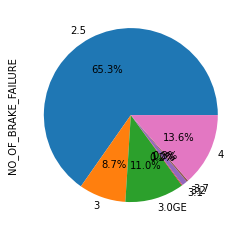

In [53]:
#plt.pie(x=brakes_by_gen["NO_OF_BRAKE_FAILURE"], labels=brakes_by_gen.index)
brakes_by_gen.plot.pie(autopct="%.1f%%")

In [54]:
gen_count = veh_details_df.groupby('GENERATION')['NO_OF_BRAKE_FAILURE'].count()

In [55]:
gen_count

GENERATION
2.5      53
3        17
3.0GE    35
3.1       1
3.2       4
3.7       3
4        25
Name: NO_OF_BRAKE_FAILURE, dtype: int64

In [56]:
#plt.pie(x=gen_count["NO_OF_BRAKE_FAILURE"], labels=gen_count.index)
#gen_count.plot.pie(autopct="%.1f%%")

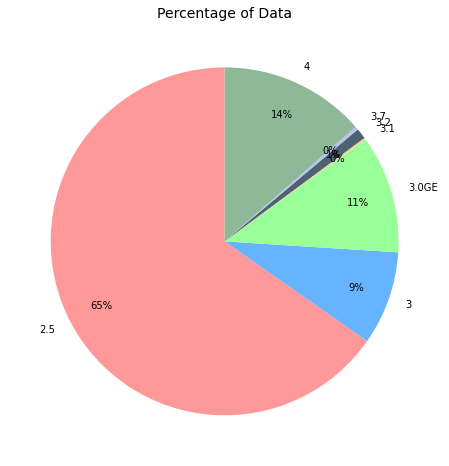

In [57]:
pie, ax = plt.subplots(figsize=[11,8])
labels = gen_count.keys()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#4F6272', '#B7C3F3', '#8EB897']
plt.pie(x=brakes_by_gen, autopct="%1.0f%%", labels=labels,colors=colors, pctdistance=0.8,startangle=90)
plt.title("Percentage of Data", fontsize=14);


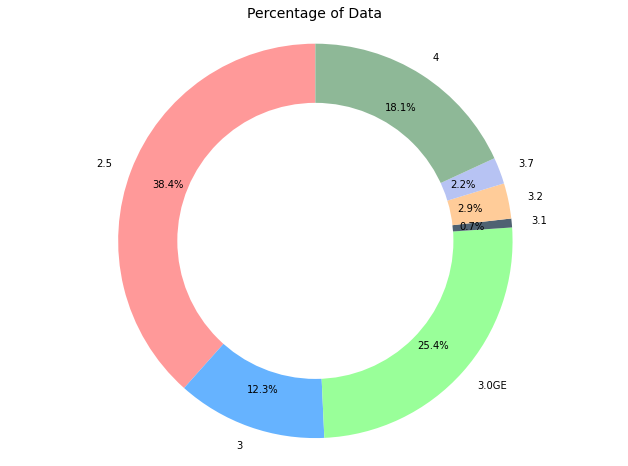

In [58]:

pie, ax = plt.subplots(figsize=[11,8])
labels = gen_count.keys()
colors = ['#ff9999','#66b3ff','#99ff99','#4F6272','#ffcc99', '#B7C3F3', '#8EB897']
ax.pie(x=gen_count, autopct="%1.1f%%", labels=labels,colors=colors, pctdistance=0.8,startangle=90)
plt.title("Percentage of Data", fontsize=14)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')  
#plt.tight_layout()
plt.show()
pie.savefig("PercentageofData.png")


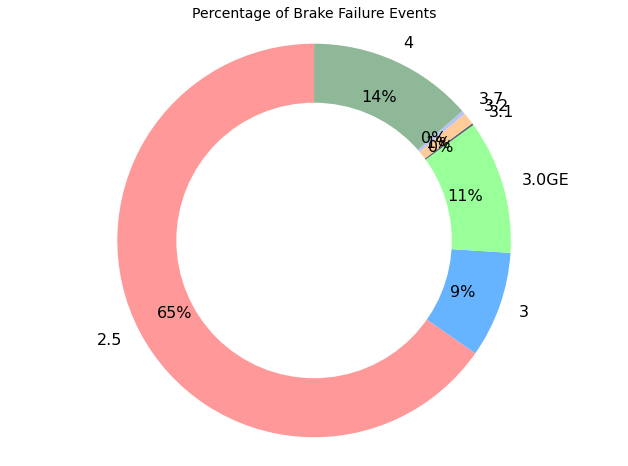

In [59]:
pie, ax = plt.subplots(figsize=[11,8])
labels = brakes_by_gen.keys()
explode = (0, 0, 0, 0,0,0,0)
colors = ['#ff9999','#66b3ff','#99ff99','#4F6272','#ffcc99', '#B7C3F3', '#8EB897']
ax.pie(x=brakes_by_gen, autopct="%1.0f%%", labels=labels,colors=colors,explode=explode, pctdistance=0.8,labeldistance=1.1,startangle=90,textprops={'fontsize': 16})
plt.title("Percentage of Brake Failure Events", fontsize=14)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')  
#plt.tight_layout()
plt.show()
pie.savefig("PercentageofBrakeFailure.png")

# Calculating percentage of total trips by generation

In [60]:
IMEI_date_range = pd.read_csv('Date Min and Max by IMEI.csv')

In [61]:
IMEI_date_range.head()

,IMEI,MIN(DATA_TIME),MAX(DATA_TIME)
0,869307033749671,09-18-2021 17:52:00.52,10-11-2021 02:31:15.80
1,869307032989955,09-06-2021 05:21:01.98,09-08-2021 08:00:00.22
2,869313033248110,07-15-2021 01:08:00.66,08-14-2021 21:33:10.14
3,869313032526797,03-19-2022 17:00:45.64,04-07-2022 16:01:12.37
4,869313034648607,04-05-2022 18:17:00.01,04-14-2022 02:35:39.22


In [62]:
IMEI_date_range_vehkey = pd.merge(IMEI_date_range,veh_gen, on='IMEI', how='left')

In [63]:
IMEI_date_range_vehkey

,IMEI,MIN(DATA_TIME),MAX(DATA_TIME),VEHICLE_KEY,BIKE_ID,FRAME_NUMBER,PLATE_NUMBER,TYPE_NAME,PRODUCT_NAME,SOURCE_CREATED_AT,...,CREATED_AT,UPDATED_AT,BIKE_TOKEN,GENERATION,MANUFACTURER,FIRST_OPERATIONAL_DATE_PST,FIRST_OPERATIONAL_REGION,FRAME_GENERATION,IS_JUMP,REPORTING_GENERATION
0,869307033749671,09-18-2021 17:52:00.52,10-11-2021 02:31:15.80,3886893,11267910,SJ00201811001716,ABSTCP,scooter,Lime-S,51:10.0,...,54:01.2,54:01.2,SNF23MCD6XO6Y,2.5,Jiuding,6/25/2021,914.0,2.5,N,NaN
1,869307032989955,09-06-2021 05:21:01.98,09-08-2021 08:00:00.22,5857765,11375212,SJ00201904018681,FVDELW,scooter,Lime-S,53:36.0,...,53:12.5,53:12.5,6WYPATLMEI2V6,2.5,Jiuding,5/11/2021,18860.0,2.5,N,2.5
2,869307032989955,09-06-2021 05:21:01.98,09-08-2021 08:00:00.22,488336,11375212,SJ00201904018681,FVDELW,scooter,Lime-S,53:36.0,...,52:29.2,54:09.4,6WYPATLMEI2V6,2.5,Jiuding,5/11/2021,18860.0,2,N,2.5
3,869313033248110,07-15-2021 01:08:00.66,08-14-2021 21:33:10.14,1642706,11438644,SJ00201904042737,PUNFAM,scooter,Lime-S,29:16.0,...,00:36.4,04:04.5,NH6NKI36L3YQQ,2.5,Jiuding,9/13/2019,1246.0,2,N,2.5
4,869313033248110,07-15-2021 01:08:00.66,08-14-2021 21:33:10.14,412468,11437023,SJ00201904042737,UDUZEJ,scooter,Lime-S,56:48.0,...,52:29.2,01:17.3,GN7NQRMSUJSA5,2.5,Jiuding,3/9/2020,1080.0,2,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,869313035751541,03-09-2022 22:19:03.00,03-16-2022 02:16:36.64,6069491,11854718,SJ00382104001567,YZWWWT,scooter,Lime-S,16:42.0,...,53:12.5,53:12.5,FRP7G7NN3ZGTQ,4,Jiuding,8/29/2021,1177.0,4,N,4
587,869307033950709,08-27-2021 23:11:06.08,08-29-2021 20:07:14.08,5834160,11825911,SJ00372104001376,DRGVMR,scooter,Lime-S,28:09.0,...,53:12.5,53:12.5,P6HW5G2I75U3Z,3.2,Jiuding,7/17/2021,405.0,3.2,N,3
588,869307033950709,08-27-2021 23:11:06.08,08-29-2021 20:07:14.08,3615753,11825911,SJ00372104001376,DRGVMR,scooter,Lime-S,28:09.0,...,01:26.4,54:09.4,P6HW5G2I75U3Z,3.2,Jiuding,7/17/2021,405.0,3.7,N,3
589,869307033908855,02-21-2022 06:13:00.31,02-23-2022 17:15:00.03,6025008,11792973,SJ00372103003765,LTQHPJ,scooter,Lime-S,43:46.0,...,53:12.5,53:57.8,Q66VX3YIYHAPS,3.2,Jiuding,7/27/2021,4.0,3.2,N,3


In [64]:
brake_failour_per_veh

,IMEI,NO_OF_BRAKE_FAILURE
0,869307030836489,8
1,869307032016650,1
2,869307032235458,1
3,869307032584848,1
4,869307032592494,12
...,...,...
134,869313035861878,13
135,869313035895108,2
136,869313036031323,6
137,869313036376728,2


In [65]:
IMEI_no_brake_issue =pd.merge(brake_failour_per_veh,IMEI_date_range_vehkey, on='IMEI', how='outer')

In [66]:
IMEI_no_brake_issue[IMEI_no_brake_issue['NO_OF_BRAKE_FAILURE'].isnull()]

,IMEI,NO_OF_BRAKE_FAILURE,MIN(DATA_TIME),MAX(DATA_TIME),VEHICLE_KEY,BIKE_ID,FRAME_NUMBER,PLATE_NUMBER,TYPE_NAME,PRODUCT_NAME,...,CREATED_AT,UPDATED_AT,BIKE_TOKEN,GENERATION,MANUFACTURER,FIRST_OPERATIONAL_DATE_PST,FIRST_OPERATIONAL_REGION,FRAME_GENERATION,IS_JUMP,REPORTING_GENERATION
306,869307032989955,NaN,09-06-2021 05:21:01.98,09-08-2021 08:00:00.22,5857765.0,11375212.0,SJ00201904018681,FVDELW,scooter,Lime-S,...,53:12.5,53:12.5,6WYPATLMEI2V6,2.5,Jiuding,5/11/2021,18860.0,2.5,N,2.5
307,869307032989955,NaN,09-06-2021 05:21:01.98,09-08-2021 08:00:00.22,488336.0,11375212.0,SJ00201904018681,FVDELW,scooter,Lime-S,...,52:29.2,54:09.4,6WYPATLMEI2V6,2.5,Jiuding,5/11/2021,18860.0,2,N,2.5
308,869313032526797,NaN,03-19-2022 17:00:45.64,04-07-2022 16:01:12.37,2014257.0,11339011.0,NaN,YKEVTM,scooter,Lime-S,...,00:31.7,01:06.0,O74NBAFRJXRQN,3,NaN,6/25/2019,4557.0,NaN,N,3
309,869313032526797,NaN,03-19-2022 17:00:45.64,04-07-2022 16:01:12.37,2013993.0,11339011.0,SF10301811005124,YKEVTM,scooter,Lime-S,...,00:45.0,01:49.4,O74NBAFRJXRQN,3,Fujita,6/25/2019,4557.0,3,N,3
310,869313032526797,NaN,03-19-2022 17:00:45.64,04-07-2022 16:01:12.37,2015177.0,11535236.0,SZ00341906006240,CBSGZE,scooter,Lime-S,...,00:24.5,54:09.4,BTAXCL46UR6D4,3.0GE,Zhuoyuan,8/28/2019,221.0,3.4,N,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,869313035751541,NaN,03-09-2022 22:19:03.00,03-16-2022 02:16:36.64,6069491.0,11854718.0,SJ00382104001567,YZWWWT,scooter,Lime-S,...,53:12.5,53:12.5,FRP7G7NN3ZGTQ,4,Jiuding,8/29/2021,1177.0,4,N,4
588,869307033950709,NaN,08-27-2021 23:11:06.08,08-29-2021 20:07:14.08,5834160.0,11825911.0,SJ00372104001376,DRGVMR,scooter,Lime-S,...,53:12.5,53:12.5,P6HW5G2I75U3Z,3.2,Jiuding,7/17/2021,405.0,3.2,N,3
589,869307033950709,NaN,08-27-2021 23:11:06.08,08-29-2021 20:07:14.08,3615753.0,11825911.0,SJ00372104001376,DRGVMR,scooter,Lime-S,...,01:26.4,54:09.4,P6HW5G2I75U3Z,3.2,Jiuding,7/17/2021,405.0,3.7,N,3
590,869307033908855,NaN,02-21-2022 06:13:00.31,02-23-2022 17:15:00.03,6025008.0,11792973.0,SJ00372103003765,LTQHPJ,scooter,Lime-S,...,53:12.5,53:57.8,Q66VX3YIYHAPS,3.2,Jiuding,7/27/2021,4.0,3.2,N,3


In [67]:
IMEI_no_brake_issue.to_csv('IMEI_no_brake_issue.csv')

In [98]:
!pip install limonade-0.10.10-py3-none-any

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement limonade-0.10.10-py3-none-any (from versions: none)
ERROR: No matching distribution found for limonade-0.10.10-py3-none-any


In [95]:
!pip install snowflake

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [96]:
SNOWFLAKE_USERNAME=	'misty.biswas@li.me'
SNOWFLAKE_PASSWORD = 'Nabanita?0806021'

In [97]:
from limonade import snowflake

snowflake.query_df(sql)

ImportError: ignored